In this notebook I describe how I used matplotlib to create illustraions for week 2 of my geometric measure theory course. This code accompany's a blog post where I go into a bit more detail: https://jonasazzam.wordpress.com/2021/01/12/illustrating-covering-lemmas-using-matplotlib/. 

One nice feature is that there is an accompanying module called "gmt" that I've been using so that I can write 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gmt import Ball, plot_ball, plot_balls, plot_circle, plot_circles, plot_centers


We have imported a class called "Ball", where objects in this class represent Euclidean balls with a ceter x and radius r.

In [2]:
#The unit ball

B = Ball([0,0],1)

print(B.x)
print(B.r)

[0 0]
1


This class also has several methods that mimic common operations in mathematical arguments using balls.

In [6]:
#We can dilate balls by factors and translate them by numpy arrays

#After dilating the ball by factor 2 and translating it up by one, we get the ball of radius 2 centered at [0,1]
print(2*B+np.array([0,1]))

Ball((0, 1), 2)


We have also imported some commands for plotting balls that we'll use to illustrate various covering lemmas below.

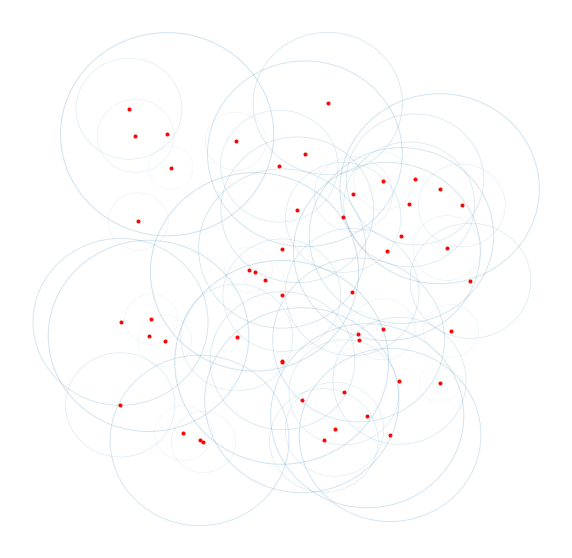

In [8]:


    
def get_random_balls(m, d=2, low=.05, high=.3):
    X = np.random.rand(m,2)
    R =  low + np.random.rand(m)*(high-low)
    
    collection = [Ball(x,r) for x,r in zip(X,R)]
    
    return collection
    
collection = get_random_balls(m=50, d=2, low=.05, high=.3)

collection

plot_circles(collection, centers = "red", alpha=.2)



# 5r Covering

The 5r Covering Theorem says that for any collection $\mathscr{B}$ of balls in a metric space with unifromly bounded radii, there is a subset $\mathscr{B}'\subseteq \mathscr{B}$ of *disjoint* balls so that 

$$\bigcup_{B\in\mathscr{B}}B\subseteq \bigcup_{B\in \mathscr{B}'}5B.$$

The proof in the case of a finite number of balls is not so bad: 

1) order the balls from largest to smallest, add the firsts ball to our new collection $\mathscr{B}'$.
2) Suppose we have visited the first $n$ balls in our list and we have arrived at the (n+1)st. If the ball intersects any ball in our collection $\mathscr{B}'$, we throw it away; otherwise we add it to $\mathscr{B}'$. 

For a finite collection of balls, this process terminates and $\mathscr{B}'$ consists of disjoint balls by construction. If some ball $B\in \mathscr{B}$ is not in this collection, that means it must have intersected a *larger* ball $B'$ already in $\mathscr{B'}$ at the time (which is why we went in descending order). Since the radius $r_{B}$ of $B$ is at most the radius $r_{B'}$ of $B'$, its easy to show that $B\subseteq 5B'$. Thus, every ball $B\in\mathscr{B}$ is contained in $5B'$ for some $B'\in \mathscr{B}'$. This finishes the proof (for finite collections). 

The proof gives instructions for a simple algorithm to find a 5r subcover:

In [11]:
def Five_R_subcovering(Cover):
    
    #Slightly different from the proof, we will arrange our balls in descending order,
    #but below we will work through the list from back to front, i.e. from largest to smallest.
    
    Cover = sorted(Cover,key=lambda x:x.r)
    
    #We make an empty list that will consist of balls that form our subcover.
    
    subcover = list()
    
    #We add the largest element to our subcover first and pop it from the end of our cover.
    
    subcover.append(Cover.pop())
    
    
    while Cover: #While there are still balls in our cover we haven't visited...
        
        #We consider the largest remaining ball.
        
        B = Cover.pop()
        
        #We assume we'll add it to our subcollection until proven otherwise.
        
        add = True
        
        #Now we check whether B intersects any ball already in our subcollection
        
        for C in subcover:
            if B.intersects(C):
                
                #If B intersects a ball C from the subcollection, we decide not to add it to 
                #the subcollection and we end the loop.
                
                add=False
                break
                
        #If 
        if add==True:
            subcover.append(B)
            
    return subcover

Let's test this by plotting a random collection of balls, and then their 5r-subcover

/Users/jazzam/Google Drive/Colab Notebooks/Math/gmt.py:416: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return ax.add_patch(Circle(tuple(ball.x), ball.r, **kwargs))


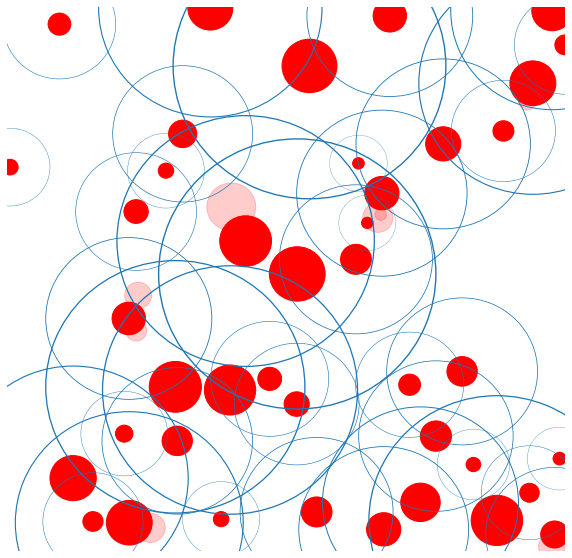

In [12]:
from matplotlib.patches import Wedge



collection = get_random_balls(m=50, d=2, low=.01, high=.05)

fig,ax = plt.subplots(figsize=(10,10))

plot_balls(collection, ax=ax, alpha=.2, color="red")
ax.axis("off")
    

subcollection = Five_R_subcovering(collection)


plot_balls(subcollection, ax=ax, color="red", edgecolor="black")

dilates = [5*B for B in subcollection]

plot_circles(dilates, ax=ax, color="black")




# Besicovitch Covering Theorem

This theorem states that, for any collection of balls $\mathscr{C}$ in $\mathbb{R}^{d}$ whose centers form a bounded set $A$, there is a number $N$ depending on $d$ and at most $N$ collections of disjoint balls $\mathscr{B}_{1},...,\mathscr{B}_{n}$ s that

$$\mathbb{1}_{A} \leq \sum_{i=1}^{n}\sum_{B\in \mathscr{B}_i}\mathbb{1}_{B} \leq N. $$

In [13]:
#For this algorithm I decided to use deques rather than lists to make the process a bit more efficient.

from collections import deque


def subcover_of_bounded_overlap(Cover):

    
    #We sort the balls in ascending order and convert them to a deque
    
    Cover = deque(sorted(Cover,key=lambda x:x.r))

    #We now create a subcovering of bounded overlap, and we start by adding the last/largest element of our Cover.

    Subcover=deque()

    Subcover.append(Cover.pop())
    

    while Cover: #While there are still balls in the cover we haven't visited.
        
        #We select the next largest ball
        
        next_ball = Cover.pop()
        
        #We assume we will keep the next ball until proven otheriwse
        
        keep_next_ball = True
        
        #If the next ball's center is in any previously selected ball, we discard it
        
        for ball in Subcover:
            if next_ball.x in ball:
                keep_next_ball = False
                break
                
        if keep_next_ball==True:
            
            #We append on the left of our new subcover so that the resulting deque of balls is still from
            #smallest to largest, so when we start popping balls from the deque again later we do so from
            # largest to smallest. 
            
            Subcover.appendleft(next_ball)
            
    return Subcover

            
def Besicovitch_covering(Cover):
    
    
                
    Subcover = subcover_of_bounded_overlap(Cover)
    
    #We now have a Subcover which will have bounded overlap, but now we need to partition this into 
    #disjoint subcovers
    
    #Notice that the balls in Subcover are now in ascending order since we appended smaller balls on the left.
    
    Subcovers = deque([Subcover])
    
    #We iterate through balls from largest to small. 
    
    Disjoint_Collection = deque()
    Disjoint_Collection.append(Subcovers[0].pop())
    Disjoint_Collections = deque([Disjoint_Collection])
    
    
    #Below, we go through each ball of our subcollection from largest to smallest and create
    #new subcollections as follows: we add the last/largest element from Subcover to a new collection.
    #Inductively, if we encounter a ball that doesn't intersect any ball from some subcollection we've created,
    #then we add it to that collection; otherwise, we create a new subcollection. The proof of the Besicovitch covering
    #theorem shows that we at most create 4^d such subcollections. 
    
    while Subcover:
        B=Subcover.pop()
        new_collection = True
        for collection in Disjoint_Collections:
            add_to_this_collection=True
            for b in collection:
                if b.intersects(B):
                    add_to_this_collection=False
                    break
            if add_to_this_collection==True:
                collection.append(B)
                new_collection=False
                break
        if new_collection == True:
            new_collection = deque([B])
            Disjoint_Collections.append(new_collection)
            
    return Disjoint_Collections
     



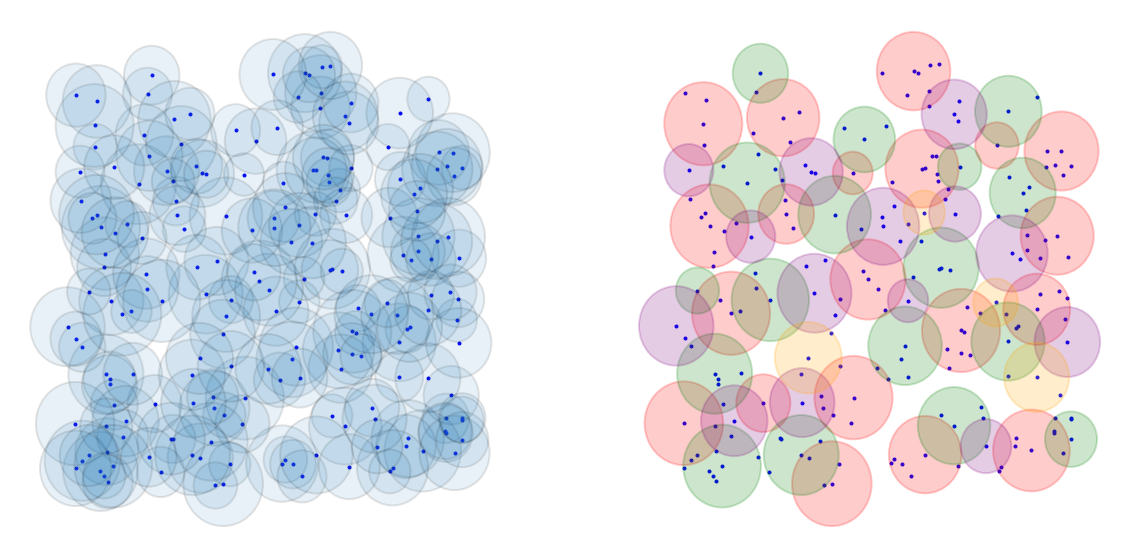

In [16]:
fig, ax = plt.subplots(1,2, figsize = (20,10))

colors = ["red","green","purple","orange","brown","blue","cyan"]

collection = get_random_balls(m=200, d=2, low=.05, high=.1)

plot_balls(collection, ax=ax[0], linewidth=2, edgecolor="black",alpha=.1)

disjoint_subcovers = Besicovitch_covering(collection)

for i, subcover in enumerate(disjoint_subcovers):
    plot_balls(subcover, ax=ax[1],  linewidth=2, edgecolor="black",color=colors[i], alpha=.2)

for a in ax:
    plot_centers(collection, ax=a, color="blue")
    a.axis("off")

Below is some code for illustrating the Vitali Covering Theorem. For context, see the blog post mentioned earlier, or see the video https://youtu.be/n2xfxst0tFA where the theorem is discussed.

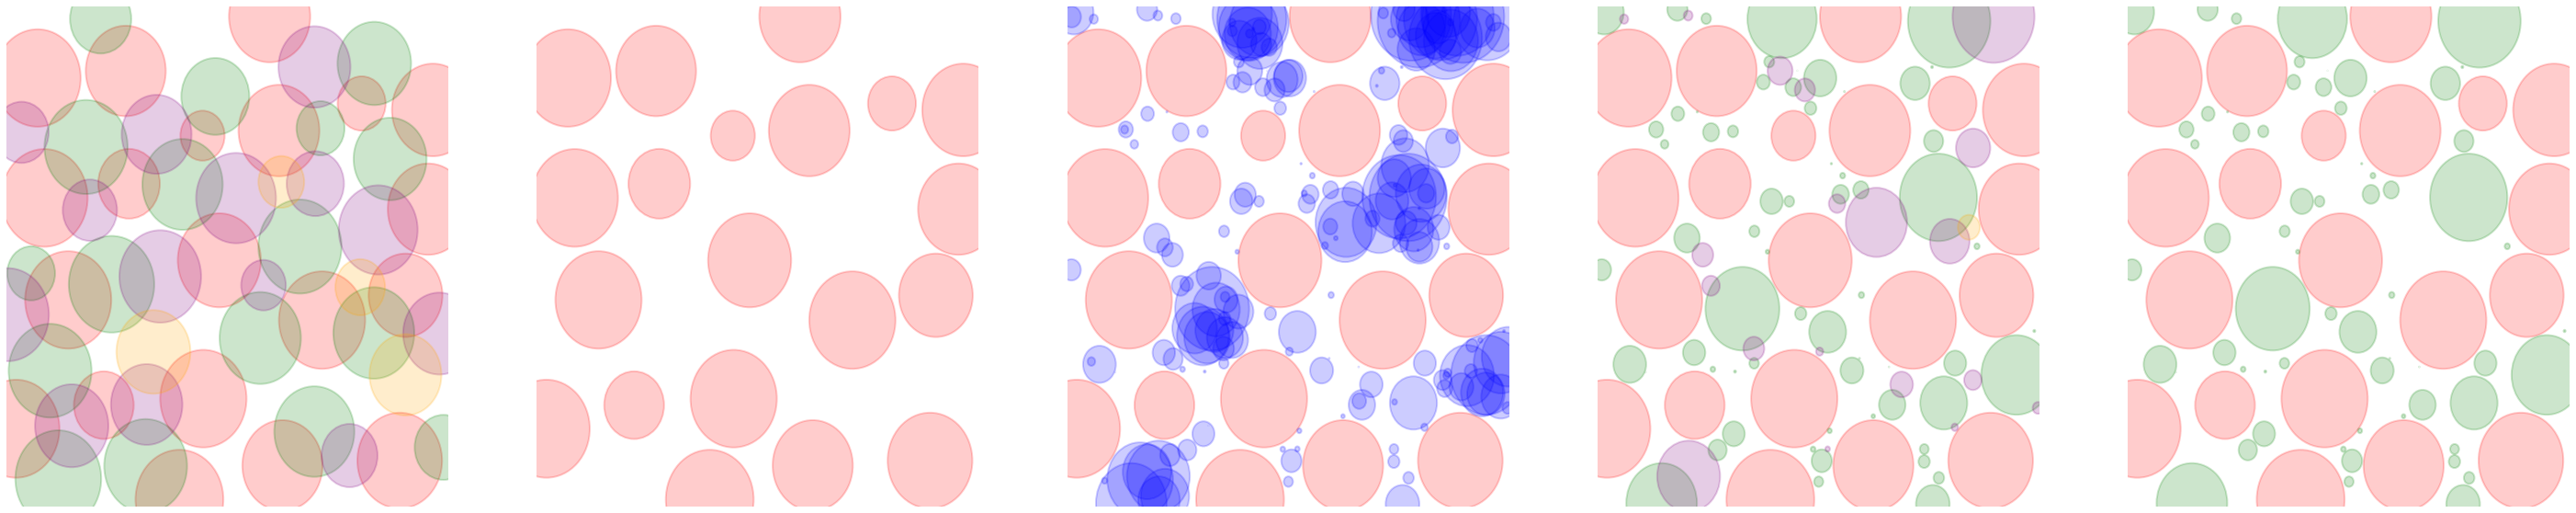

In [18]:

m=1000
new_balls = get_random_balls(m, d=2, low=.0001, high=.1)

disjoint_from_subcollection = list()
for B in new_balls:
    add = True
    for D in disjoint_subcovers[0]:
        if B.intersects(D):
            add=False
            break
    if add==True:
        disjoint_from_subcollection.append(B)

fig,ax = plt.subplots(1,5, figsize=(50,10))
for a in ax:
    a.axis("off")


for i,c in enumerate(disjoint_subcovers):
    plot_balls(c,ax=ax[0],linewidth=2, edgecolor="black",color=colors[i], alpha=.2)
    


plot_balls(disjoint_subcovers[0],ax=ax[1],linewidth=2, edgecolor="black",color=colors[0], alpha=.2)



plot_balls(disjoint_subcovers[0],ax=ax[2],linewidth=2, edgecolor="black",color=colors[0], alpha=.2)

plot_balls(disjoint_from_subcollection,ax=ax[2],linewidth=2, edgecolor="black",color="blue", alpha=.2)


new_subcovers = Besicovitch_covering(disjoint_from_subcollection)   


plot_balls(disjoint_subcovers[0],ax=ax[3],linewidth=2, edgecolor="black",color=colors[0], alpha=.2)

for i,c in enumerate(new_subcovers):
    plot_balls(c,ax=ax[3],linewidth=2, edgecolor="black",color=colors[i+1], alpha=.2)
    
    


plot_balls(disjoint_subcovers[0],ax=ax[4],linewidth=2, edgecolor="black",color=colors[0], alpha=.2)

plot_balls(new_subcovers[0],ax=ax[4],linewidth=2, edgecolor="black",color=colors[1], alpha=.2)


